# End to end Multi-class Dog Breed Classification

This notebook builds and end-to-end multi-class image classifier using TenserFlow 2.0 and TenserFlow Hub

## 1. Problem

- Identify the breed of a dog given an image of a dog.

## 2. Data

- Data from kaggle competition.
https://www.kaggle.com/competitions/dog-breed-identification

## 3. Evaluation

- The evaluation metric required is Multi class Log loss. For each image in test set, must predict probability for each of the different breeds.

## 4. Features

- Dealing with image (unstructured data) so we're using deep learning/transfer learning.
- There are 120 breeds of dogs i.e. 120 different classes.
- About 10,000+ images in the training set (train set image have labels)
- Around 10,000+ images in test set (no labels)

## Getting Workspace ready

* Import TensorFlow
* Import TensorFlow Hub
* Running on gpu

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [28]:
print("TF version: ", tf.__version__)
print("TF_hub version: ", hub.__version__)

TF version:  2.18.0
TF_hub version:  0.16.1


In [29]:
# Checking for GPU availability
print("GPU", "available (Yes Sir!!)" if tf.config.list_physical_devices("GPU") else "GPU not available sir")

GPU available (Yes Sir!!)


In [30]:
# Unzipping the data in google drive
# !unzip "drive/MyDrive/Dog_Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog_Vision/"

## Getting our data ready (Turning into Tensors)

With all ML models, our data has to be in numerical format. So turning our images into Tensors(numerical representation)

In [31]:
label_csv = pd.read_csv('drive/MyDrive/Dog_Vision/labels.csv')
print(label_csv.describe)

<bound method NDFrame.describe of                                      id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]>


In [32]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [33]:
label_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


The label contains name of dog breed of our training images

<Axes: xlabel='breed'>

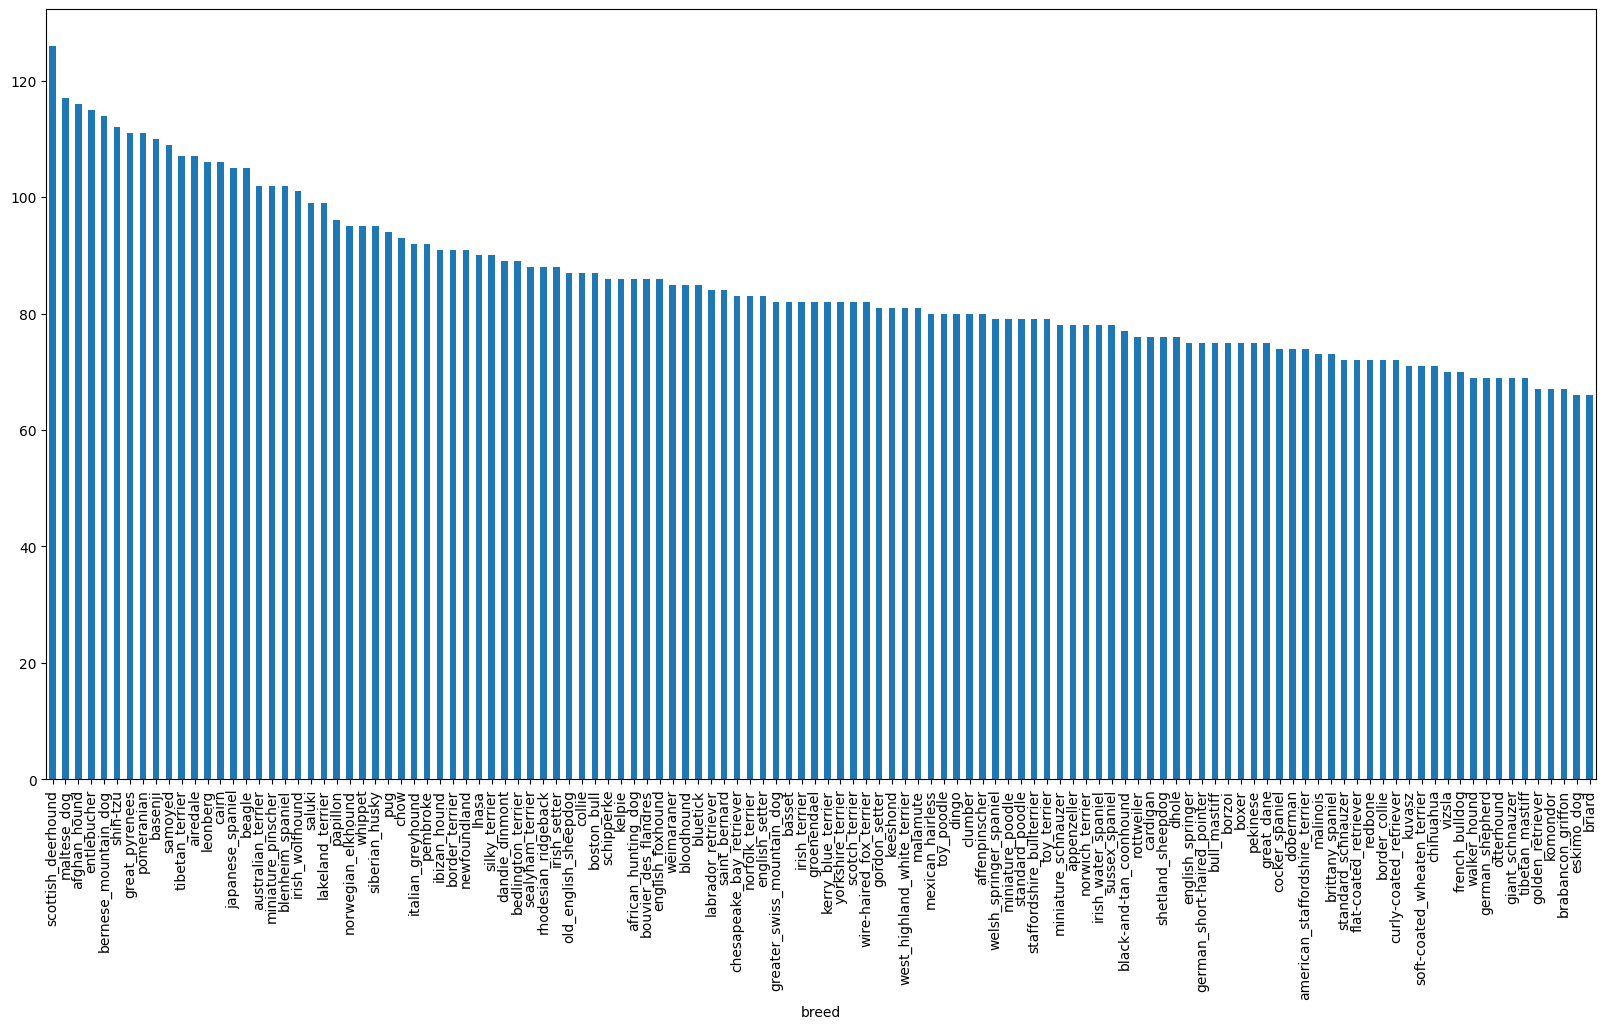

In [34]:
# How many images of each breeds
label_csv['breed'].value_counts().plot(kind='bar', x=label_csv['breed'], figsize=(20, 10))

There is enough image for all type of breed so that our model can identify them

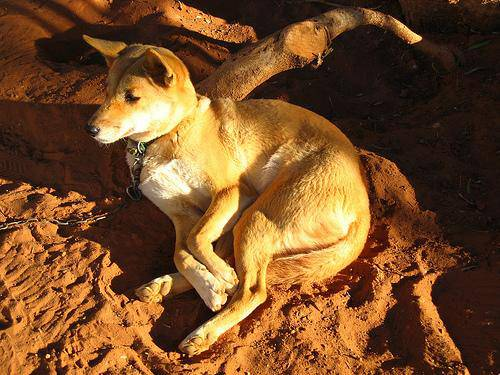

In [35]:
from IPython.display import Image
Image('drive/MyDrive/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

## Getting Images and their labels

In [36]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [37]:
# create pathnames from image ID's from label
filenames = ["drive/MyDrive/Dog_Vision/train/" + fname + ".jpg" for fname in label_csv['id']]
filenames[:10]

['drive/MyDrive/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog_Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog_Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog_Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog_Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog_Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog_Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog_Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog_Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [38]:
# checking no of files names matches with train set image files
import os
if len(os.listdir('drive/MyDrive/Dog_Vision/train/')) == len(filenames):
  print('Filenames match actual amount of files!!! Proceed.')
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files!!! Proceed.


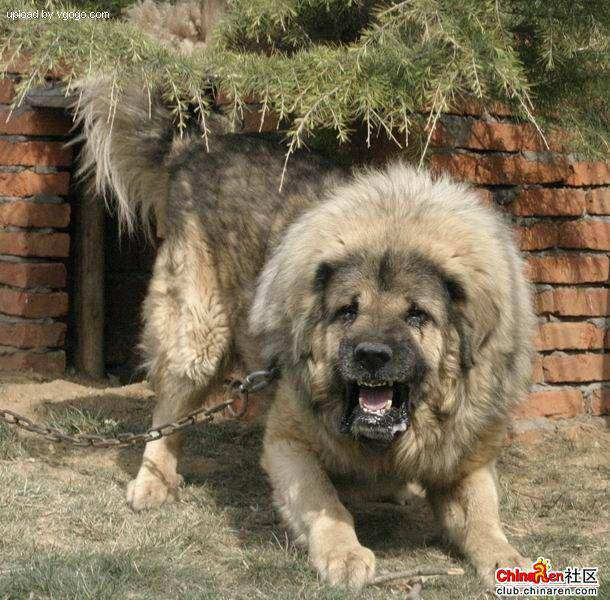

In [39]:
Image(filenames[9000])

Now that is a dog

In [40]:
print(filenames[9000])

drive/MyDrive/Dog_Vision/train/e20e32bf114141e20a1af854ca4d0ecc.jpg


In [41]:
label_csv[label_csv['id'] =="e20e32bf114141e20a1af854ca4d0ecc"]

,id,breed
9000,e20e32bf114141e20a1af854ca4d0ecc,tibetan_mastiff


In [42]:
labels = label_csv['breed']
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [43]:
len(labels)

10222

In [44]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels doesn't match number of filenames, check train directories")

Number of labels matches number of filenames!


In [45]:
# Finding unique label values
unique_breed = np.unique(labels)
len(unique_breed)

120

all the data requirements are satisfied as mentioned in kaggle

In [46]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breed

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [47]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breed for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [48]:
len(boolean_labels)

10222

In [49]:
# Example: Turning boolean labels into integers
print(labels[0])  # original label
print(np.where(unique_breed == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


labels can now be converted into numerical values.

## Creating Validation set

In [50]:
# setup X & y varibales
X = filenames
y = boolean_labels

Experimenting wiht 1000 images and increase as needed.

In [51]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000}

In [52]:
# splitting our data into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)